# Fallbacks with Branching Pipelines

In [25]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich

from dotenv import load_dotenv

load_dotenv()

HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

In [2]:
from haystack import Pipeline
from haystack.components.routers import ConditionalRouter
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.websearch.serper_dev import SerperDevWebSearch #conditional router


### We reuse the ElasticDocumentStore

In [3]:
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder

from haystack.utils import Secret


document_store = ElasticsearchDocumentStore(hosts = "http://localhost:9200")

In [4]:
document_store.filter_documents()[1]

Document(id=ca30af9db39112b8b30b423b5eecde1179eaa937cf246b3a2dc3370d613defc5, content: ' His works have left an indelible mark on literature, shaping and defining the modern fantasy genre....', meta: {'file_path': '/Users/simonamazzarino/Documents/Clearbox-repo/clearbox-ai-academy/RAG_Course/data/tolkien.txt', 'source_id': '95729082efb874f6adbd167b40d517e72164716f13b409e93ef114cbc81fcb5d', 'page_number': 1, 'split_id': 1, 'split_idx_start': 223}, score: 1.0, embedding: vector of size 384)

### Create RAG Pipeline

In [5]:
rag_prompt_template = """
Answer the following query given the documents.
If the answer is not contained within the documents, reply with 'no_answer'
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

In [6]:
query_embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever =ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 3)
prompt = PromptBuilder(template=rag_prompt_template)
generator = OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))


In [7]:
rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever",retriever )
rag.add_component("prompt_builder", prompt)
rag.add_component("llm", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder", "llm")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: ElasticsearchEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

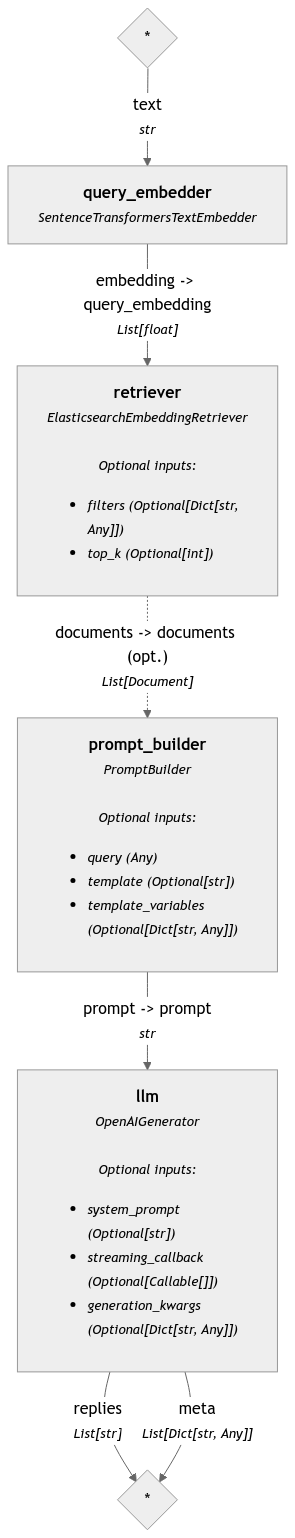

In [8]:
rag.show()

In [9]:
query = "Who is J. R.R. Tolkien?"

result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query}},
        include_outputs_from={"retriever"}
)



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
rich.print(result["llm"]["replies"][0])

John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the
most influential and celebrated figures in literary history, particularly within the realm of high fantasy.

In [11]:
query = "Who is George Martin?"
result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query}},
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
rich.print(result["llm"]["replies"][0])

no_answer

### Create Conditional Routes


Now that you got the model to respond with an answer or `no_answer`, you can create pipeline branches that are activated according to this response using the [`ConditionalRouter`](https://docs.haystack.deepset.ai/docs/conditionalrouter?utm_campaign=developer-relations&utm_source=dlai) component for this.

ConditionalRouter routes your data through different paths down the pipeline by evaluating the conditions that you specified.

The following are two different routes that the pipeline can take: if in the reply of the generator, there are the words 'no_answer', then go to the route 'go_to_websearch'. Instead, if 'no_answer' is not in the answer, then give the response and stop the pipeline.

In [13]:
routes = [
    {
        "condition": "{{'no_answer' in replies[0]|lower}}",
        "output": "{{query}}",
        "output_name": "go_to_websearch", 
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]|lower}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

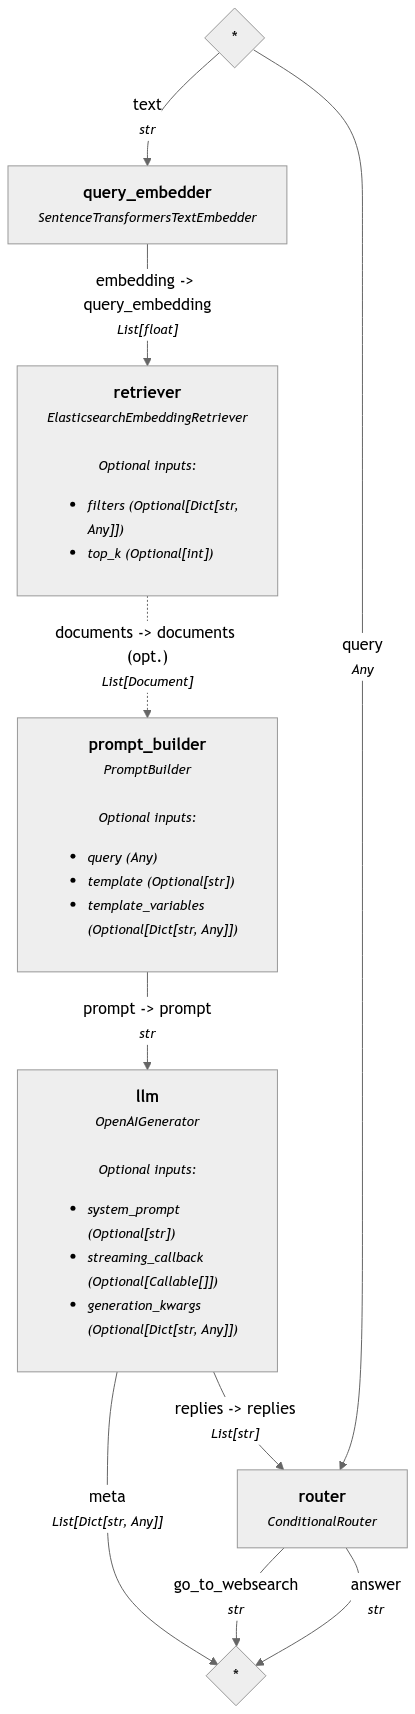

In [14]:
rag.add_component("router", ConditionalRouter(routes=routes))
rag.connect("llm.replies", "router.replies")

rag.show()

In [15]:
query = "Who is Tolkien?"

result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query},
    "router": {"query": query}} # We pass the query to the router because we need it in case we go to websearch
)

result

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 86,
     'prompt_tokens': 178,
     'total_tokens': 264,
     'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]},
 'router': {'answer': 'John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the most influential and celebrated figures in literary history, particularly within the realm of high fantasy. The success of The Hobbit marked Tolkien’s emergence as a prominent author, and his creation of Middle-earth would become a lifelong project that expanded well beyond the boundaries of a single book.'}}

In [16]:
query = "Who is George Martin?"

result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query},
    "router": {"query": query}} # We pass the query to the router because we need it in case we go to websearch
)

result

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 3,
     'prompt_tokens': 71,
     'total_tokens': 74,
     'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]},
 'router': {'go_to_websearch': 'Who is George Martin?'}}

### Create Websearch Branch


In [17]:
prompt_for_websearch = """
Answer the following query given the documents retrieved from the web.
Your answer should indicate that your answer was generated from websearch.
You can also reference the URLs that the answer was generated from

Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

### Build a Pipeline with Conditional Routes

To perform the web search, we use the components SerperDevWebSearch. You need to create an account and use an API token to access. When you give SerperDevWebSearch a query, it returns a list of the URLs most relevant to your search. It uses page snippets (pieces of text displayed under the page title in search results) to find the answers, not the whole pages.

In [26]:
WS_API_TOKEN = os.getenv("WS_API_TOKEN")

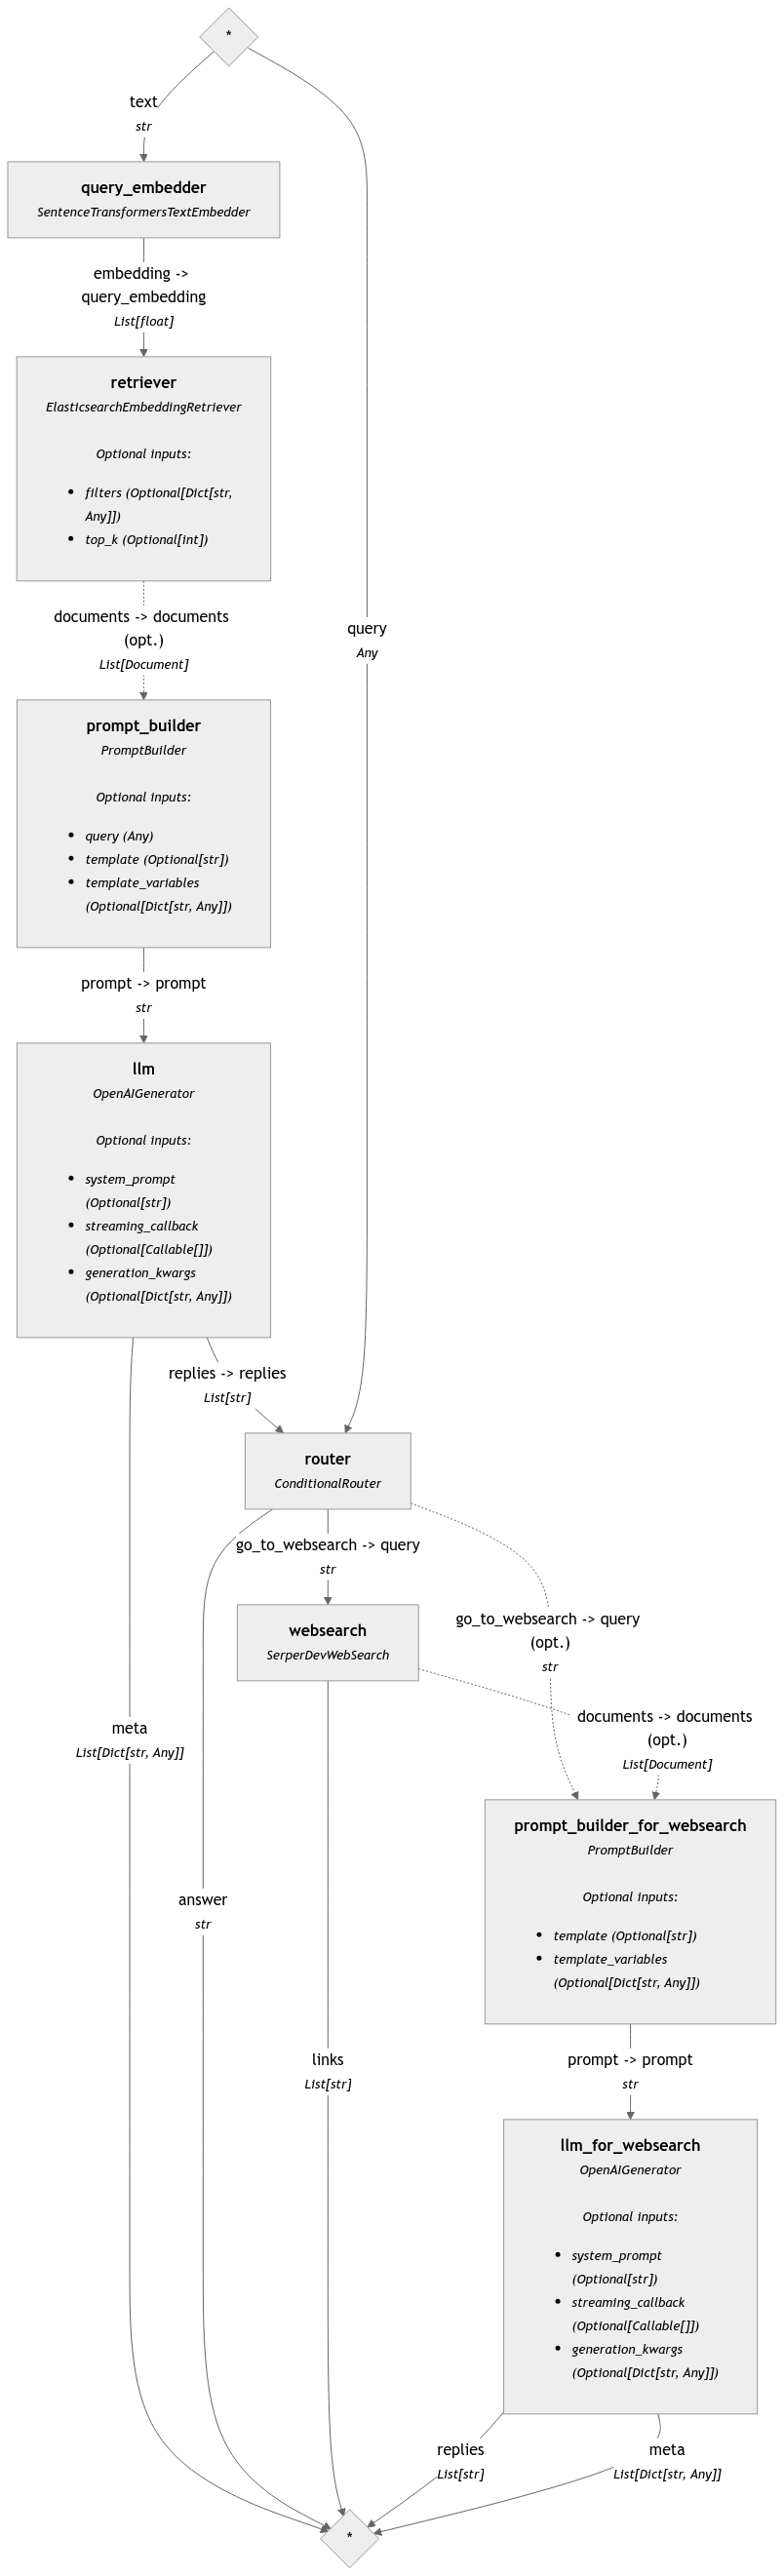

In [27]:
rag_or_websearch = Pipeline()
rag_or_websearch.add_component("query_embedder", SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2"))
rag_or_websearch.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 3))
rag_or_websearch.add_component("prompt_builder", PromptBuilder(template=rag_prompt_template))
rag_or_websearch.add_component("llm", OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN)))
rag_or_websearch.add_component("router", ConditionalRouter(routes))
rag_or_websearch.add_component("websearch", SerperDevWebSearch(api_key=Secret.from_token(WS_API_TOKEN))) 
rag_or_websearch.add_component("prompt_builder_for_websearch", PromptBuilder(template=prompt_for_websearch))
rag_or_websearch.add_component("llm_for_websearch",  OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN)))

rag_or_websearch.connect("query_embedder.embedding", "retriever.query_embedding")
rag_or_websearch.connect("retriever.documents", "prompt_builder.documents")
rag_or_websearch.connect("prompt_builder", "llm")
rag_or_websearch.connect("llm.replies", "router.replies")
rag_or_websearch.connect("router.go_to_websearch", "websearch.query")
rag_or_websearch.connect("router.go_to_websearch", "prompt_builder_for_websearch.query")
rag_or_websearch.connect("websearch.documents", "prompt_builder_for_websearch.documents")
rag_or_websearch.connect("prompt_builder_for_websearch", "llm_for_websearch")

rag_or_websearch.show()

In [28]:
query= "Who is George R.R. Martin?"

result = rag_or_websearch.run({"query_embedder": {"text": query}, 
                      "prompt_builder":{"query": query},
                      "router": {"query": query}},
                      include_outputs_from=["llm", "router", "websearch"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
result

{'llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 3,
     'prompt_tokens': 112,
     'total_tokens': 115,
     'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}],
  'replies': ['no_answer']},
 'websearch': {'links': ['https://en.wikipedia.org/wiki/George_R._R._Martin',
   'https://georgerrmartin.com/about-george/life-and-times/',
   'https://www.britannica.com/biography/George-R-R-Martin',
   'https://georgerrmartin.com/',
   'https://www.instagram.com/grrm_nm/?hl=en',
   'https://www.northwestern.edu/about/our-people/george-r.r.-martin.html',
   'https://www.imdb.com/name/nm0552333/',
   'https://www.theguardian.com/books/2018/nov/10/books-interview-george-rr-martin',
   'https://www.facebook.com/georgerrmartinofficial/'

In [30]:
rich.print(result['llm']['replies'][0])

no_answer

In [31]:
rich.print(result['llm_for_websearch']['replies'][0])

George R.R. Martin is an American author, television writer, and producer, best known for his epic fantasy series 
"A Song of Ice and Fire," which inspired the hit television series "Game of Thrones." He was born on September 20, 
1948, in Bayonne, New Jersey. Over the years, Martin has established himself as a prominent figure in the fantasy, 
horror, and science fiction genres, gaining fame for his intricate storytelling and complex characters. Notably, he
experienced mainstream success with "A Song of Ice and Fire" after working as a professional writer for several 
decades. For more details, you can refer to the sources at the following URLs: 

- https://www.biography.com/writer/george-rr-martin
- https://www.imdb.com/name/nm0550936/bio